In [2]:
import numpy as np
import pandas as pd
from log_parser import parse_keyboard_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
seg_length = 100

# List of parsed logfiles
keyboard = []
keyboard.append(parse_keyboard_log("./logs/JON/SPY/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MAR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/HEN/SOL/keyboard_actions.log"))

# Hack to get the number of segments contained in each file
lengths = [
    keyboard[0].time.iloc[-1] / seg_length,
    keyboard[1].time.iloc[-1] / seg_length,
    keyboard[2].time.iloc[-1] / seg_length,
]

# Empty lists for inserting data
X_actual = []
Y_actual = []

for k in range(len(keyboard)):
    for i in range(int(lengths[k])):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())

'''
# Display features
for i in range(len(X_actual)):
    print(X_actual[i][:10], Y_actual[i])
'''
print(f"Data samples: {len(Y_actual)}")


Data samples: 36


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( 
    f"Train score: {rfc.score(X_train, Y_train)} " +
    f"Test score: {rfc.score(X_test, Y_test)}"
)

# Predict on test set
Y_predict = rfc.predict(X_test)

# Ouput predictions vs ground truth values
for i in range(len(Y_predict)):
    print(f"Actual: {Y_test[i]:<10}  -  Predicted: {Y_predict[i]}")

Train score: 1.0 Test score: 1.0
Actual: HENSOL      -  Predicted: HENSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY


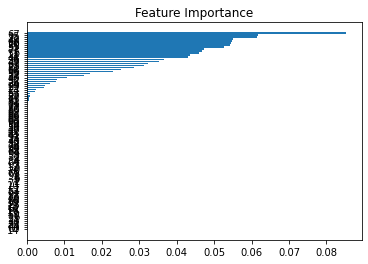

In [4]:
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(155.0, 251.66666666666666, 'X[84] <= 0.019\ngini = 0.664\nsamples = 17\nvalue = [9, 10, 8]'),
 Text(77.5, 151.0, 'X[91] <= 3.768\ngini = 0.278\nsamples = 8\nvalue = [2, 10, 0]'),
 Text(38.75, 50.333333333333314, 'gini = 0.0\nsamples = 7\nvalue = [0, 10, 0]'),
 Text(116.25, 50.333333333333314, 'gini = 0.0\nsamples = 1\nvalue = [2, 0, 0]'),
 Text(232.5, 151.0, 'X[9] <= 0.608\ngini = 0.498\nsamples = 9\nvalue = [7, 0, 8]'),
 Text(193.75, 50.333333333333314, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 8]'),
 Text(271.25, 50.333333333333314, 'gini = 0.0\nsamples = 5\nvalue = [7, 0, 0]')]

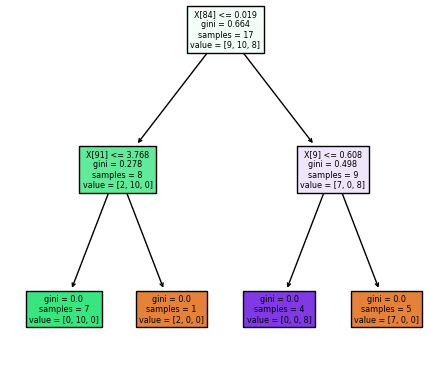

In [5]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=100)
tree.plot_tree(rfc.estimators_[0], filled = True)